In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

import layers as layers
import util as util
import networks as networks

In [210]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [3]:
def plot_results(x, y, x_plot, model, n_samp=500):
    plt.scatter(x.numpy(), y.numpy())
    f_pred_plot = model(x_plot, sample_input_layer=False, weights_type='mean').detach()
    plt.plot(x_plot.numpy(), f_pred_plot.numpy())
    
    f_samp_plot = torch.zeros(n_samp, x_plot.shape[0])
    for i in range(n_samp):
        f_samp_plot[i,:] = model(x_plot, sample_input_layer=True, weights_type='sample').detach().reshape(-1)

    for q in [.025, .05, .1]:
        ci = np.quantile(f_samp_plot.numpy(), [q, 1-q], axis=0)
        plt.fill_between(x_plot.reshape(-1).numpy(), ci[0,:], ci[1,:], alpha=.1, color='blue')

In [357]:
def plot_results_2d(x, y, x_plot, model, idx=0, n_samp=500):
    plt.scatter(x[:,idx].numpy(), y.numpy())
    f_pred_plot = model(x_plot, sample_input_layer=False, weights_type='mean').detach()
    plt.plot(x_plot[:,idx].numpy(), f_pred_plot.numpy())
    
    f_samp_plot = torch.zeros(n_samp, x_plot.shape[0])
    for i in range(n_samp):
        f_samp_plot[i,:] = model(x_plot, sample_input_layer=True, weights_type='sample').detach().reshape(-1)

    for q in [.025, .05, .1]:
        ci = np.quantile(f_samp_plot.numpy(), [q, 1-q], axis=0)
        plt.fill_between(x_plot[:,0].reshape(-1).numpy(), ci[0,:], ci[1,:], alpha=.1, color='blue')

## Basic testing

#### Layer

In [5]:
x = torch.empty((5,1)).normal_(0,1)
y = torch.randn(5,1)

rff layer

In [6]:
l = layers.RffHsLayer(1,6)

In [7]:
l.forward(x, sample=True)

tensor([[ 0.4319,  0.5514,  0.1227,  0.5538,  0.3404, -0.3607],
        [ 0.4073,  0.5573,  0.1200,  0.5553,  0.3545, -0.3663],
        [ 0.4340,  0.5508,  0.1230,  0.5537,  0.3391, -0.3602],
        [ 0.4275,  0.5525,  0.1222,  0.5541,  0.3430, -0.3617],
        [ 0.4099,  0.5567,  0.1203,  0.5551,  0.3531, -0.3657]],
       grad_fn=<MulBackward0>)

In [8]:
l.entropy()

tensor(-20.3013, grad_fn=<AddBackward0>)

In [9]:
l.cross_entropy()

tensor(32.7447, grad_fn=<AddBackward0>)

In [10]:
l.kl_divergence()

tensor(53.0460, grad_fn=<SubBackward0>)

In [11]:
l.fixed_point_updates()

Linear layer

In [12]:

h = torch.randn(5,3)
l = layers.LinearLayer(3)

In [13]:
l.fixed_point_updates(h,y)

In [14]:
l.forward(h, True)

UnboundLocalError: local variable 'w' referenced before assignment

In [ ]:
l.init_parameters()

## Infer prior

In [190]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

Dataset is sample from the prior

In [191]:
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/.1)

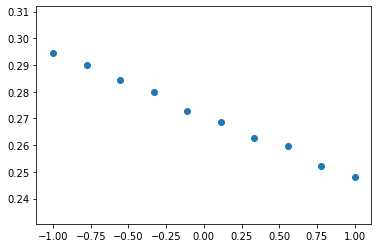

In [197]:
n_obs = 10
sig2 = .001

torch.manual_seed(1)
model.init_parameters()
x = torch.linspace(-1,1, n_obs).reshape(-1,1)
y = model.forward(x, sample=False).detach() + sig2*torch.randn(n_obs).reshape(-1,1)
plt.scatter(x.numpy(), y.numpy())

Epoch[250/1000], kl: 1052.906616, likelihood: 2.262321, elbo: -1050.595215
Epoch[500/1000], kl: 1044.439209, likelihood: 0.835122, elbo: -1042.244873
Epoch[750/1000], kl: 1036.899292, likelihood: 1.461719, elbo: -1036.358887
Epoch[1000/1000], kl: 1030.976562, likelihood: 0.789685, elbo: -1030.020142


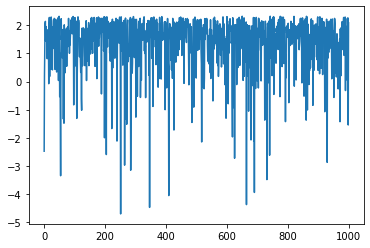

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#model.reinit_parameters(x,y,n_reinit=10) # comment out to start at truth
elbo = -networks.train(model, optimizer, x, y, n_epochs=1000, print_freq=250)
plt.plot(elbo)

In [198]:
torch.exp(model.layer_in.lognu_mu + model.layer_in.lognu_logsig2.exp()/2)

tensor([0.2478], grad_fn=<ExpBackward>)

In [199]:
torch.exp(model.layer_in.logeta_mu + model.layer_in.logeta_logsig2.exp()/2)

tensor([0.1375], grad_fn=<ExpBackward>)

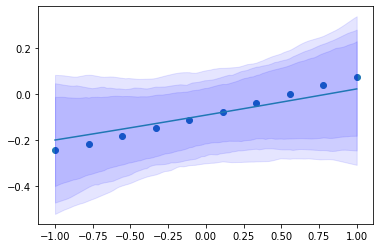

In [180]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
plot_results(x,y,x_plot, model)

In [133]:
for name, p in model.named_parameters():
    print(name)

layer_in.lognu_mu
layer_in.lognu_logsig2
layer_in.logeta_mu
layer_in.logeta_logsig2


## Very simple

In [248]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

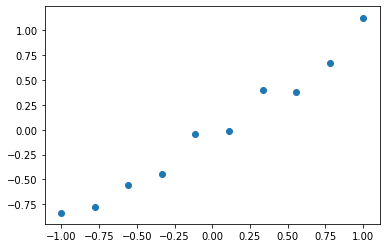

In [249]:
n_obs = 10
sig2 = .1
x = torch.linspace(-1,1,n_obs).reshape(-1,1)
y = x + sig2*torch.randn(n_obs).reshape(-1,1)
plt.scatter(x.numpy(), y.numpy()) 

In [250]:
torch.manual_seed(2)
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/sig2)

before: 59.67872619628906
temp:  0.0
after: 54.718017578125
Epoch[1/20], kl: 9.869433, likelihood: 0.949994, elbo: -8.927835
before: 8.929020881652832
temp:  0.1
after: 8.745442390441895
Epoch[2/20], kl: 9.823696, likelihood: -1.317722, elbo: -11.005574
before: 10.97335433959961
temp:  0.2
after: 10.537339210510254
Epoch[3/20], kl: 9.718320, likelihood: -4.440721, elbo: -14.082626
before: 13.76612663269043
temp:  0.3
after: 10.941112518310547
Epoch[4/20], kl: 9.613235, likelihood: -0.384644, elbo: -10.143505
before: 10.055156707763672
temp:  0.4
after: 9.806396484375
Epoch[5/20], kl: 9.497922, likelihood: 1.407524, elbo: -8.178403
before: 8.213655471801758
temp:  0.5
after: 7.655297756195068
Epoch[6/20], kl: 9.372961, likelihood: -0.641543, elbo: -9.933913
before: 10.049519538879395
temp:  0.6
after: 8.739078521728516
Epoch[7/20], kl: 9.247330, likelihood: -3.077036, elbo: -12.289177
before: 12.284509658813477
temp:  0.7
after: 12.230781555175781
Epoch[8/20], kl: 9.133636, likelihood: 

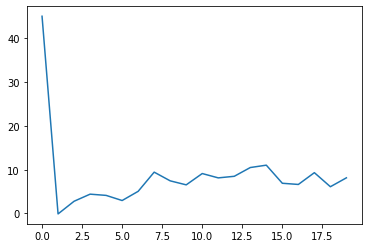

In [251]:
torch.manual_seed(2)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(x,y,n_reinit=10) 
elbo = -networks.train(model, optimizer, x, y, n_epochs=20, n_rep_opt=1000, print_freq=1)
plt.plot(-elbo)

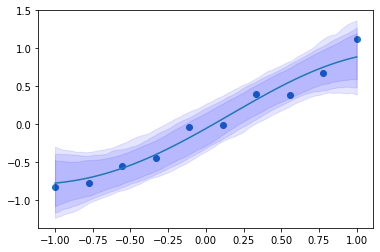

In [252]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
plot_results(x,y,x_plot, model)

In [253]:
model.loss(x, y, x_linear=None, temperature=1)

tensor([7.1398], grad_fn=<AddBackward0>)

In [254]:
for name, p in model.named_parameters():
    print(name, p.detach().item())

layer_in.lognu_mu -0.26410552859306335
layer_in.lognu_logsig2 -7.030379772186279
layer_in.logeta_mu 0.3566124439239502
layer_in.logeta_logsig2 -7.023773193359375


In [255]:
model.layer_in.vtheta_b

tensor([2.3028])

In [256]:
model.layer_in.psi_b

tensor([1.7004])

## Checking KL

In [128]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [129]:
torch.manual_seed(2)
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/sig2)

entropy: lognormal

In [130]:
# My code
self = model.layer_in
util.lognormal_entropy(self.lognu_logsig2.exp().sqrt().log(), self.lognu_mu, 1)


tensor(-2.5203, grad_fn=<AddBackward0>)

In [131]:
# Torch 
m = torch.distributions.log_normal.LogNormal(self.lognu_mu, \
                                             self.lognu_logsig2.exp().sqrt())
m.entropy()

tensor([-2.5203], grad_fn=<AddBackward0>)

entropy: invgamma

In [132]:
# My code
util.entropy_invgamma(self.vtheta_a, self.vtheta_b)


tensor(2.6055, grad_fn=<SumBackward0>)

In [133]:
# Scipy
from scipy.stats import invgamma
ig = invgamma(a=self.vtheta_a.item(), scale=self.vtheta_b.item())
ig.entropy()

array(2.60545596)

## Very simple 2D

In [383]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

Text(0.5, 0, 'x2')

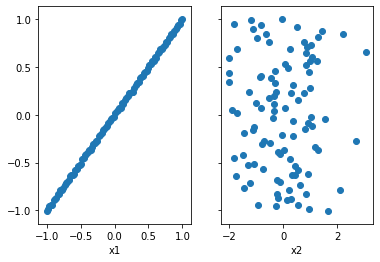

In [384]:
n_obs = 100
sig2 = .01
x1 = torch.linspace(-1,1,n_obs).reshape(-1,1)
x2 = torch.randn(n_obs).reshape(-1,1)
x = torch.cat([x1,x2],dim=1)

y = x1 + sig2*torch.randn(n_obs).reshape(-1,1)

fix, ax = plt.subplots(1,2,sharey=True)

ax[0].scatter(x[:,0].numpy(), y.numpy()); ax[0].set_xlabel('x1')
ax[1].scatter(x[:,1].numpy(), y.numpy()); ax[1].set_xlabel('x2')

In [417]:
torch.manual_seed(2)
model = networks.RffHs(2, 1, dim_hidden=50, sig2_inv=1/sig2)

before: 1653.8682861328125
temp:  0.0
after: 1608.32666015625
Epoch[1/100], kl: 14.758945, likelihood: 130.950638, elbo: 117.143417
before: -116.74821472167969
temp:  0.02
after: -116.90808868408203
Epoch[2/100], kl: 14.759881, likelihood: 124.457909, elbo: 110.078835
before: -111.3617172241211
temp:  0.04
after: -111.81927490234375
Epoch[3/100], kl: 14.760319, likelihood: 122.241249, elbo: 108.703217
before: -108.83293151855469
temp:  0.06
after: -109.1109619140625
Epoch[4/100], kl: 14.760695, likelihood: 127.829834, elbo: 112.487770
before: -111.98165893554688
temp:  0.08
after: -112.48896026611328
Epoch[5/100], kl: 14.761305, likelihood: 124.410980, elbo: 108.397781
before: -109.09846496582031
temp:  0.1
after: -110.41873168945312
Epoch[6/100], kl: 14.762444, likelihood: 131.230789, elbo: 116.874382
before: -116.29564666748047
temp:  0.12
after: -115.25346374511719
Epoch[7/100], kl: 14.762967, likelihood: 131.273224, elbo: 117.749069
before: -115.96134948730469
temp:  0.14
after: -1

temp:  1
after: -116.35440063476562
Epoch[61/100], kl: 14.444332, likelihood: 131.818192, elbo: 115.676422
before: -116.59402465820312
temp:  1
after: -116.32720947265625
Epoch[62/100], kl: 14.435150, likelihood: 122.020805, elbo: 108.625595
before: -112.11011505126953
temp:  1
after: -113.08653259277344
Epoch[63/100], kl: 14.427238, likelihood: 129.908020, elbo: 115.451057
before: -114.84906768798828
temp:  1
after: -114.54358673095703
Epoch[64/100], kl: 14.418058, likelihood: 124.874855, elbo: 107.708534
before: -113.5594711303711
temp:  1
after: -114.16314697265625
Epoch[65/100], kl: 14.410142, likelihood: 128.527634, elbo: 109.525986
before: -114.56541442871094
temp:  1
after: -115.17200469970703
Epoch[66/100], kl: 14.401234, likelihood: 126.670868, elbo: 111.346207
before: -110.10369873046875
temp:  1
after: -112.44813537597656
Epoch[67/100], kl: 14.391237, likelihood: 131.733551, elbo: 115.452682
before: -116.89608764648438
temp:  1
after: -117.34649658203125
Epoch[68/100], kl: 1

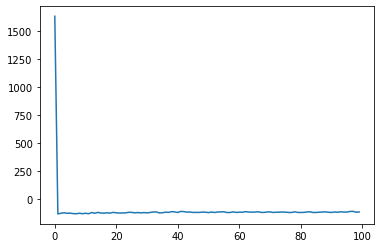

In [418]:
torch.manual_seed(2)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(x,y,n_reinit=10) 
elbo = -networks.train(model, optimizer, x, y, n_epochs=100, n_rep_opt=100, print_freq=1)
plt.plot(-elbo)

In [408]:
model.layer_in.lognu_mu.data = torch.log(torch.tensor([1.]))
model.layer_in.logeta_mu.data = torch.log(torch.tensor([1., 1e-10]))

model.fixed_point_updates(x, y, x_linear=False, temperature=1)

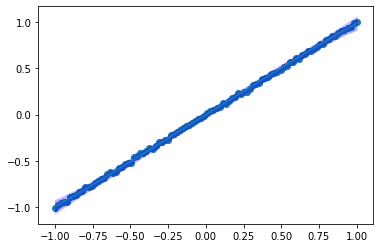

In [404]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
x_plot = torch.cat([x_plot, torch.zeros(x_plot.shape[0]).reshape(-1,1)],dim=1)
plot_results_2d(x,y,x_plot, model)

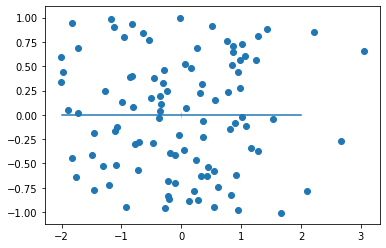

In [409]:
x_plot = torch.linspace(-2,2,100).reshape(-1,1)
x_plot = torch.cat([torch.zeros(x_plot.shape[0]).reshape(-1,1), x_plot],dim=1)
plot_results_2d(x,y,x_plot, model, idx=1)

In [419]:
for name, p in model.named_parameters():
    print(name, p.detach())

layer_in.lognu_mu tensor([-0.2276])
layer_in.lognu_logsig2 tensor([-8.6950])
layer_in.logeta_mu tensor([-0.0590, -0.5292])
layer_in.logeta_logsig2 tensor([-8.6634, -8.2638])


In [421]:
model.layer_in.lognu_mu.exp()

tensor([0.7964], grad_fn=<ExpBackward>)

In [420]:
model.layer_in.logeta_mu.exp()

tensor([0.9427, 0.5891], grad_fn=<ExpBackward>)

In [412]:
model.layer_in.logeta_mu[0].item()

0.0

In [413]:
model.layer_in.logeta_mu[1].item()

-23.025850296020508

In [414]:
util.reparam_trick_lognormal(model.layer_in.lognu_mu, model.layer_in.lognu_logsig2.exp(), False)


tensor([1.0001], grad_fn=<ExpBackward>)

In [415]:
util.reparam_trick_lognormal(model.layer_in.logeta_mu, model.layer_in.logeta_logsig2.exp(), False)


tensor([1.0001e+00, 1.0001e-10], grad_fn=<ExpBackward>)

In [416]:
model.print_state(x, y, 1+1, 2)

Epoch[2/2], kl: 25.575773, likelihood: 136.753220, elbo: 108.370468


## Simple model

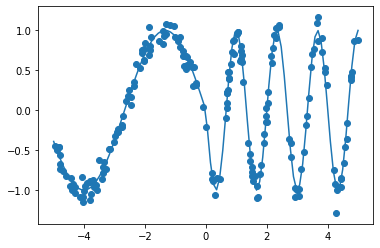

In [422]:
# Toy data
x_true = torch.tensor(np.linspace(-5,5,100).reshape(-1,1), dtype=torch.float)
x, x_val, y, y_val, y_scale, y_true = util.gen_toy_data(num_train=200, x_true=x_true)

plt.scatter(x.numpy(), y.numpy())
plt.plot(x_true.numpy(), y_true.numpy())

In [423]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [434]:
model = networks.RffHs(x.shape[1],y.shape[1], dim_hidden=300, sig2_inv=1/(0.1**2))
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [435]:
for name, param in model.named_parameters():
    print(name, param.data)

layer_in.lognu_mu tensor([0.0087])
layer_in.lognu_logsig2 tensor([-9.0083])
layer_in.logeta_mu tensor([0.0124])
layer_in.logeta_logsig2 tensor([-9.0182])


In [426]:
model.reinit_parameters(x,y,n_reinit=10)

In [427]:
elbo = -networks.train(model, optimizer, x, y, n_epochs=100, n_rep_opt=100, print_freq=1000)


before: 29218.064453125
temp:  0.0
after: 26675.576171875
before: 2442.88330078125
temp:  0.02
after: 2292.513916015625
before: 2319.8330078125
temp:  0.04
after: 2296.27685546875
before: 2266.487060546875
temp:  0.06
after: 2310.221923828125
before: 2276.000244140625
temp:  0.08
after: 2264.427490234375
before: 2275.76806640625
temp:  0.1
after: 2285.462158203125
before: 2278.872802734375
temp:  0.12
after: 2289.820556640625
before: 2254.696044921875
temp:  0.14
after: 2329.604248046875
before: 2265.58056640625
temp:  0.16
after: 2439.882568359375
before: 2266.653564453125
temp:  0.18
after: 2273.63427734375
before: 2273.5244140625
temp:  0.2
after: 2274.303466796875
before: 2274.42626953125
temp:  0.22
after: 2268.474853515625
before: 2270.47265625
temp:  0.24
after: 2328.16162109375
before: 2269.05859375
temp:  0.26
after: 2271.652099609375
before: 2253.68115234375
temp:  0.28
after: 2258.758544921875
before: 2265.99609375
temp:  0.3
after: 2295.541259765625
before: 2394.39086914062

In [19]:
#plt.plot(elbo.numpy())

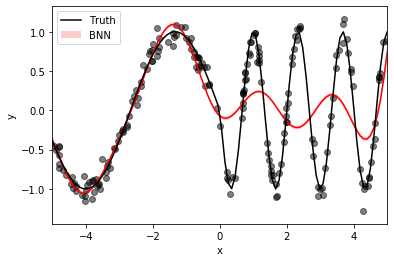

In [431]:
def plot_varbnn(bnn, n_samp, x_true):
    #bnn = networks.RffHs(x.shape[1],y.shape[1], dim_hidden=100, sig2_inv=1/.1)
    y_samps=np.array([bnn(x_true, sample_input_layer=True, weights_type='sample').view(-1).detach().numpy() for _ in range(n_samp)])
    sns.tsplot(y_samps, time=x_true.numpy(),ci='sd',color='red')
    plt.scatter(x.numpy(),y.numpy(), color='k', alpha=.5)
    plt.plot(x_true.numpy(),y_true.numpy(), color='k')
    plt.legend(['Truth','BNN'])

    plt.xlabel('x')
    plt.ylabel('y')  
    
    
plot_varbnn(model, 100, x_true)



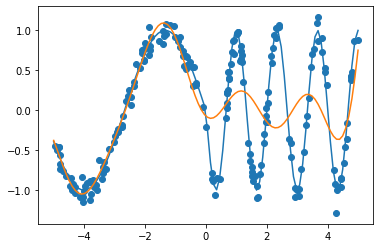

In [432]:
plt.scatter(x.numpy(), y.numpy())
plt.plot(x_true.numpy(), y_true.numpy())
plt.plot(x_true.numpy(), model.forward(x_true, sample_input_layer=False, weights_type='mean').detach().numpy())


In [433]:
for name, param in model.named_parameters():
    print(name, param.data)

layer_in.lognu_mu tensor([-0.0911])
layer_in.lognu_logsig2 tensor([-11.5330])
layer_in.logeta_mu tensor([-0.0950])
layer_in.logeta_logsig2 tensor([-11.5245])
